# Governance Trends in India
94-775 Unstructured Data Analytics for Policy: Final Project \
Nathan Deron, Muriel Pokol, and Shreya Prabhu

TextBlob must be installed to run this code. \
Raw datafiles used for this analysis can be found at:
* https://www.kaggle.com/therohk/india-headlines-news-dataset
* https://www.kaggle.com/rajanand/rajyasabha

In [1]:
#Import packages
import pandas as pd
import numpy as np
import glob
import re
import string
import codecs
import spacy
from textblob import TextBlob, Word, Blobber
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from dateutil.parser import parse
from datetime import datetime
from matplotlib_venn import venn2
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#Code borrowed and adapted from George Chen, Carnegie Mellon University#
#Define function to remove punctuation and whitespace, and lowercase all text
def makeWordList(str_object):
    
    corpus_text = str(str_object)
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

# Data Pre-Processing

### Religion Pre-Processing

This section includes all of the code required to turn the raw datafiles from Kaggle into the religious headline and religious parliamentary questions dataset used in the first part of our analysis. This was done using a "religion-related words" vocabulary developed by the members of this analysis team specifically to address the policy question at hand. Word lemmas were extracted using spacy and matched against words in this vocabulary. These datasets were also split into pre- and post-election datasets based on with the date of the election (headlines) or the date of taking office (parliament).

In [3]:
#Read in headlines dataset
data = pd.read_csv("india-news-headlines.csv")

In [4]:
#Split dataset for upload to GitHub
india_news_headlines_1 = data.iloc[0:593984, :]
india_news_headlines_2 = data.iloc[593984:1187969, :]
india_news_headlines_3 = data.iloc[1187969:1781953, :]
india_news_headlines_4 = data.iloc[1781953:2375938, :]
india_news_headlines_5 = data.iloc[2375938:2969922, :]

In [5]:
#Write split data to csv files for upload
india_news_headlines_1.to_csv("india-news-headlines-1.csv", index=False)
india_news_headlines_2.to_csv("india-news-headlines-2.csv", index=False)
india_news_headlines_3.to_csv("india-news-headlines-3.csv", index=False)
india_news_headlines_4.to_csv("india-news-headlines-4.csv", index=False)
india_news_headlines_5.to_csv("india-news-headlines-5.csv", index=False)

In [6]:
#define religious vocabulary for creating religion-related datasets
religious_vocab = ['religion', 'religious', 'hindu', 'hinduism',
                  'islam', 'muslim', 'christianity', 'christian', 'sikh',
                  'sikhism', 'temple', 'mosque', 'church', 'divine', 'god', 'gods',
                  'prayer', 'prayers', 'priest', 'clergy', 'imam', 'monk', 'dharma',
                  'vedas', 'worship', 'worshippers', 'worshipers' 'worshipper', 'worshiper', 'ayodhya',
                   'babri', 'hindutva','lynching','ethnic', 'purity','nationalism', 'nationalist',
                   'rss', 'sangh'
                  ]

In [7]:
#Split headline data on 2014 election into pre and post sets
data_pre = data[data['publish_date'] <= 20140501]
data_post = data[data["publish_date"] > 20140501]

In [8]:
#Generate religious flags for pre- and post-election datasets
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
pre_mask = []
for headline in np.array(data_pre["headline_text"]):
    parsed = nlp(headline)
    religious_flag = False
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in religious_vocab:
                religious_flag = True
    pre_mask.append(religious_flag)
        
post_mask = []
for headline in np.array(data_post["headline_text"]):
    parsed = nlp(headline)
    religious_flag = False
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in religious_vocab:
                religious_flag = True
    post_mask.append(religious_flag)

In [9]:
#Generate religious datasets
pre = pd.Series(pre_mask)
religious_pre = data_pre[pre.values]
post = pd.Series(post_mask)
religious_post = data_post[post.values]

In [10]:
#Write religious datasets to csv files
religious_pre.to_csv("religious_headlines_pre.csv", index=False)
religious_post.to_csv("religious_headlines_post.csv", index=False)

In [17]:
#Import parliamentary Q&A dataset
li = []

for file in glob.glob('rajyasabha/rajyasabha_questions_and_answers*.csv'):
    data = pd.read_csv(file, encoding='ISO-8859-1')
    li.append(data)
    
parliament_qs = pd.concat(li, axis = 0, ignore_index = True)

In [18]:
#Apply religion filter to parliamentary dataset
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
answer_mask = []
for answer in np.array(parliament_qs["answer"]):
    parsed = nlp(str(answer))
    religious_flag = False
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in religious_vocab:
                religious_flag = True
    answer_mask.append(religious_flag)

In [19]:
#Generate religious parliamentary answer dataset
answer_mask = pd.Series(answer_mask)
religious_answers = parliament_qs[answer_mask.values]

In [20]:
#Split religious parliamentary dataset based on when the new government came into office
answers_pre_mask = []
for date in religious_answers['answer_date'].to_numpy():
    if parse(date) < parse('2014.05.26'):
        answers_pre_mask.append(True)
    else:
        answers_pre_mask.append(False)
answers_pre_mask = pd.Series(answers_pre_mask)
religious_answers_pre = religious_answers[answers_pre_mask.values]
religious_answers_post = religious_answers[~answers_pre_mask.values]
religious_answers_pre.to_csv("religious_answers_pre.csv", index=False)
religious_answers_post.to_csv("religious_answers_post.csv", index=False)

## Full Datasets Pre-Processing

This code prepares the all datasets, religious and full, for clustering, topic modeling, and sentiment analysis. This includes removing punctuation, lowercase-ing all words, and vectorizing the documents.

In [22]:
#Process parliamentary answers
processed_answers = []

for str_object in list(parliament_qs["answer"]):
    processed_answers.append(makeWordList(str_object))

In [29]:
#Import headlines dataset
li = []

for file in glob.glob('./india-news-headlines*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
headlines_raw = pd.concat(li, axis = 0, ignore_index = True)

In [30]:
#Process headlines, delete headlines object, sample 10% of processed headlines
import random
processed_headlines = []
random.seed(42)
headlines = random.sample(list(headlines_raw["headline_text"]), round(len(headlines_raw)/10))
                          
for str_object in headlines:
    processed_headlines.append(makeWordList(str_object))

In [31]:
#Import religious headline pre- and post-election datasets
li = []

for file in glob.glob('./religious_headlines_pre*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
religious_headlines_pre = pd.concat(li, axis = 0, ignore_index = True)

li = []

for file in glob.glob('./religious_headlines_post*.csv'):
    data = pd.read_csv(file)
    li.append(data)
    
religious_headlines_post = pd.concat(li, axis = 0, ignore_index = True)

In [32]:
#Process religious headlines
processed_religious_headlines_pre = []

for str_object in list(religious_headlines_pre["headline_text"]):
    processed_religious_headlines_pre.append(makeWordList(str_object))
    
processed_religious_headlines_post = []

for str_object in list(religious_headlines_post["headline_text"]):
    processed_religious_headlines_post.append(makeWordList(str_object))

# Dataset Description and Exploration

This code generates time series graphs of when the documents in each datasets were published (headlines) or put to parliament.

Text(0, 0.5, 'Quantity')

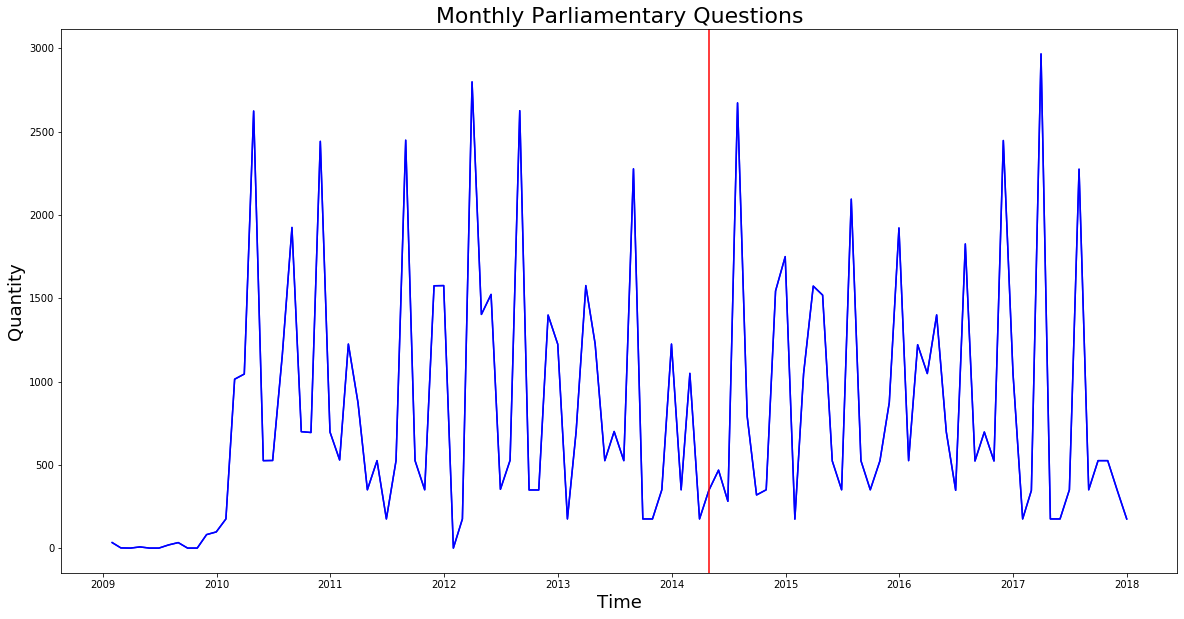

In [33]:
#Process Parliament Q&A dataset, aggregating by month and producing a plot of the date distribution
answer_dates = pd.DataFrame(pd.to_datetime(parliament_qs["answer_date"]))
final_answer_dates = []
for date in answer_dates["answer_date"]:
    if isinstance(date, datetime):
        final_answer_dates.append([date, 1])
final_answer_dates = pd.DataFrame(final_answer_dates)
#final_answer_dates.reset_index().set_index(0)

plt.figure(figsize=(20,10))
agg = final_answer_dates.resample('M', on=0).count()
plt.plot(agg, c='blue')
election = parse("2014-05-01")
plt.axvline(x=election, c='red')
plt.title("Monthly Parliamentary Questions", size=22)
plt.xlabel("Time", size = 18)
plt.ylabel("Quantity", size = 18)

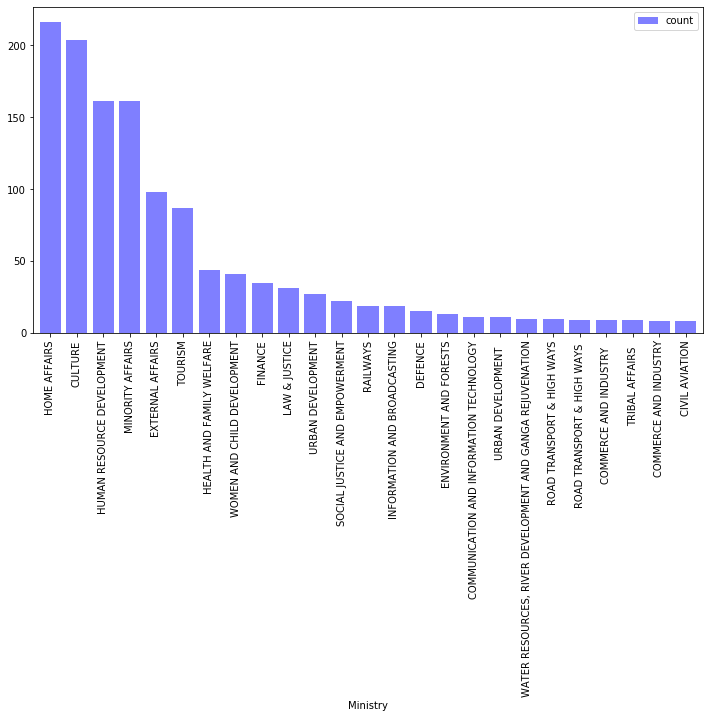

In [34]:
#Process Parliament Religous Answers dataset and plot the number in each ministry 
answers_pre = pd.read_csv('religious_answers_pre.csv')
answers_pre = pd.DataFrame(answers_pre)
answers_pre['answer_date']= pd.to_datetime(answers_pre['answer_date'], format='%d.%m.%Y')

answers_post = pd.read_csv('religious_answers_post.csv')
answers_post = pd.DataFrame(answers_post)
answers_post['answer_date']= pd.to_datetime(answers_post['answer_date'], format='%d.%m.%Y')

all_answers = pd.concat([answers_pre, answers_post])
all_grouped = all_answers.groupby('ministry')['answer'].count()
all_grouped = all_grouped.reset_index(name='count').sort_values(['count'], ascending=False).head(25)

all_grouped.plot(figsize=(12, 6), kind='bar', x='ministry', width=0.8, facecolor='blue', alpha=0.5)
plt.xlabel('Ministry')
plt.xticks(rotation=90) 
plt.show()

Text(0, 0.5, 'Quantity')

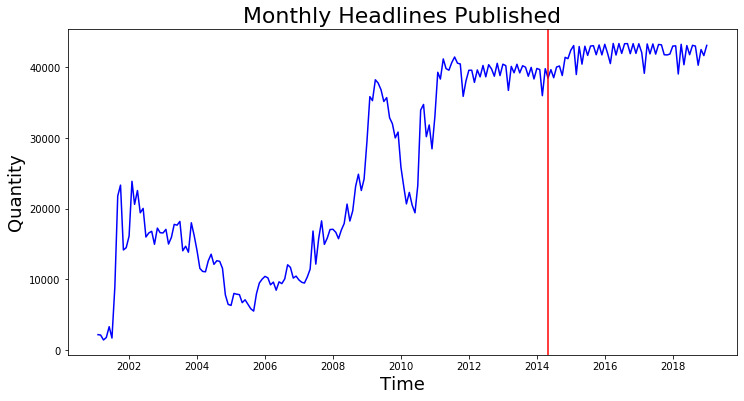

In [35]:
#Process headlines dataset, aggregating by month and producing datetime plot
headline_dates = pd.DataFrame(pd.to_datetime(headlines_raw["publish_date"]))
final_headline_dates = []
for date in list(headlines_raw["publish_date"]):
    datetime = datetime.strptime(str(date), "%Y%m%d")
    final_headline_dates.append(datetime)
final_headline_dates = pd.DataFrame(final_headline_dates)
#plot
plt.figure(figsize=(12,6))
agg = final_headline_dates.resample('M', on=0).count()
plt.plot(agg, c='blue')
election = parse("2014-05-01")
plt.axvline(x=election, c='red')
plt.title("Monthly Headlines Published", size=22)
plt.xlabel("Time", size = 18)
plt.ylabel("Quantity", size = 18)

# Sentiment Analysis on Religion Datasets

This analysis was performed to focus on our original question about how the conversation regarding reglion in the media and in government had changed after the election, expecting to see more negative polarity to the text post-election.  Instead, we found stability in the polarity of both the headlines and the Parliament responses.  This was unexpected but prompted us to look at the different topics more generally in both headlines and in Parliament, explored in the following section.

In [36]:
def detect_polarity(text):
    '''
    Applies sentiment analysis to a piece of text.
    Returns polarity with 1 as pos and 0 as neg.
    '''
    return TextBlob(text).sentiment.polarity

### Headlines

In [37]:
# Read in pre-election headlines data
headlines_pre = pd.read_csv('religious_headlines_pre.csv')
headlines_pre = pd.DataFrame(headlines_pre)

# Read in post-election headlines data
headlines_post = pd.read_csv('religious_headlines_post.csv')
headlines_post = pd.DataFrame(headlines_post)

In [38]:
# Find polarity of each headline in pre-election dataset
polarity_pre = []
for i in range(headlines_pre.shape[0]):
    polarity_pre.append(detect_polarity(headlines_pre.iloc[i,2]))

# Find polarity of each headline in post-election dataset
polarity_post = []
for i in range(headlines_post.shape[0]):
    polarity_post.append(detect_polarity(headlines_post.iloc[i,2]))

In [39]:
# Add polarity scores to dataframe
headlines_pre['Polarity'] = polarity_pre
headlines_post['Polarity'] = polarity_post

print('Pre-Election Average Sentiment:', headlines_pre['Polarity'].mean())
print('Post-Election Average Sentiment:', headlines_post['Polarity'].mean())

Pre-Election Average Sentiment: 0.018221962807317686
Post-Election Average Sentiment: 0.01956247873249208


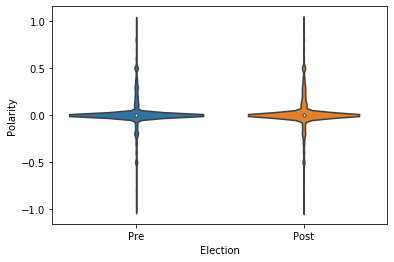

In [40]:
headlines_pre['Election'] = "Pre"
headlines_post['Election'] = "Post"

# Combine pre and post headlines into one dataframe
all_headlines = pd.concat([headlines_pre, headlines_post])
sns.violinplot(y='Polarity', x='Election', data=all_headlines)

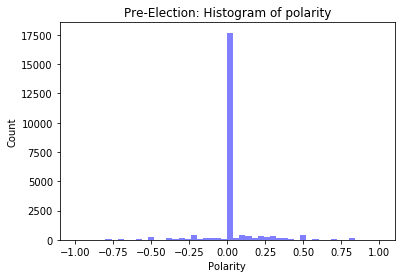

In [41]:
num_bins = 50
n, bins, patches = plt.hist(headlines_pre.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Pre-Election: Histogram of polarity')
plt.show()

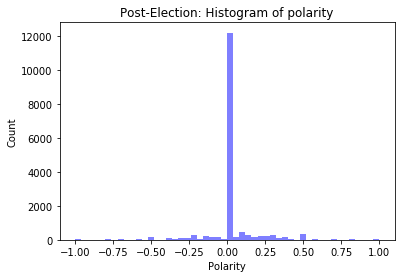

In [42]:
num_bins = 50
n, bins, patches = plt.hist(headlines_post.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Post-Election: Histogram of polarity')
plt.show()

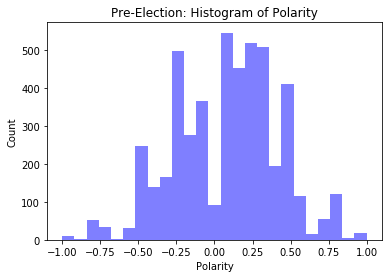

In [43]:
filter_pre = headlines_pre[headlines_pre['Polarity']!=0] #remove 0s to get a clearer picture

num_bins = 25
n, bins, patches = plt.hist(filter_pre.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Pre-Election: Histogram of Polarity')
plt.show()

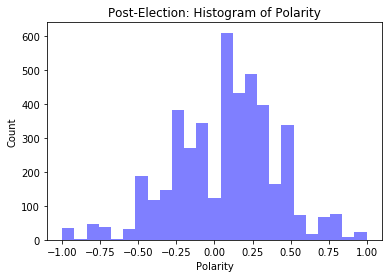

In [44]:
filter_post = headlines_post[headlines_post['Polarity']!=0] #remove 0s to get a clearer picture

num_bins = 25
n, bins, patches = plt.hist(filter_post.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Post-Election: Histogram of Polarity')
plt.show()

### Parliament Answers

In [55]:
# Read in pre-election data
answers_pre = pd.read_csv('religious_answers_pre.csv')
answers_pre = pd.DataFrame(answers_pre)

# Read in post-election data
answers_post = pd.read_csv('religious_answers_post.csv')
answers_post = pd.DataFrame(answers_post)

In [56]:
# Find polarity of each headline in pre-election dataset
polarity_pre = []
for i in range(answers_pre.shape[0]):
    polarity_pre.append(detect_polarity(answers_pre.iloc[i,0]))
    
# Find polarity of each headline in post-election dataset
polarity_post = []
for i in range(answers_post.shape[0]):
    polarity_post.append(detect_polarity(answers_post.iloc[i,0]))

In [57]:
# Add polarity scores to dataframe
answers_pre['Polarity']  = polarity_pre
answers_post['Polarity'] = polarity_post

print('Pre-Election Average Sentiment:', answers_pre['Polarity'].mean())
print('Post-Election Average Sentiment:', answers_post['Polarity'].mean())

Pre-Election Average Sentiment: 0.050982870079264365
Post-Election Average Sentiment: 0.05313852135071022


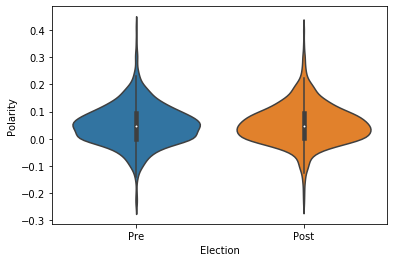

In [58]:
answers_pre['Election']  = "Pre"
answers_post['Election'] = "Post"

# Combine pre and post headlines into one dataframe
all_answers = pd.concat([answers_pre, answers_post])
sns.violinplot(y='Polarity', x='Election', data=all_answers)

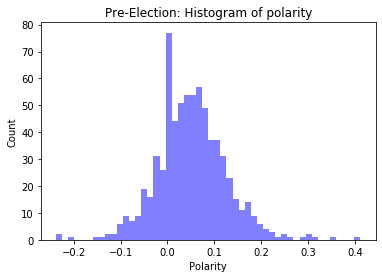

In [59]:
num_bins = 50
n, bins, patches = plt.hist(answers_pre.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Pre-Election: Histogram of polarity')
plt.show()

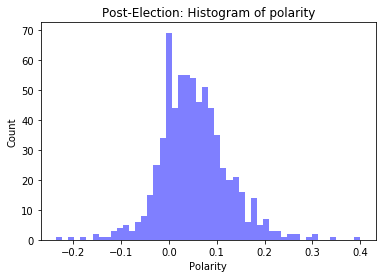

In [60]:
num_bins = 50
n, bins, patches = plt.hist(answers_post.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Post-Election: Histogram of polarity')
plt.show()

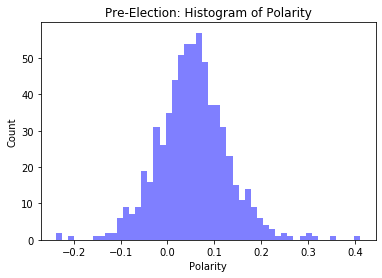

In [63]:
filter_pre = answers_pre[answers_pre['Polarity']!=0] #remove 0s to get a clearer picture

num_bins = 50
n, bins, patches = plt.hist(filter_pre.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Pre-Election: Histogram of Polarity')
plt.show()

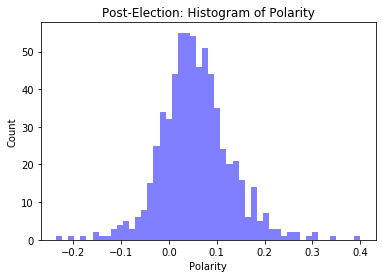

In [64]:
filter_post = answers_post[answers_post['Polarity']!=0] #remove 0s to get a clearer picture

num_bins = 50
n, bins, patches = plt.hist(filter_post.Polarity, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Post-Election: Histogram of Polarity')
plt.show()

# Topic Modeling - Religious Headlines

Here we generated topics for the religious headlines to see if there were any trends that we could glean from religious media coverage.

In [65]:
#Use TfidfVectorizer to transform religious headlines
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_pre         = TfidfVectorizer(min_df=100, stop_words="english", max_df=0.8)
rel_headlines_pre_fit  = vectorizer_pre.fit(processed_religious_headlines_pre)
X_rel_headlines_pre    = vectorizer_pre.fit_transform(processed_religious_headlines_pre).toarray()

vectorizer_post        = TfidfVectorizer(min_df=100, stop_words="english", max_df=0.8)
rel_headlines_post_fit = vectorizer_post.fit(processed_religious_headlines_post)
X_rel_headlines_post   = vectorizer_post.fit_transform(processed_religious_headlines_post).toarray()

In [66]:
#Generate seperate topic models for pre and post
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 10

lda_rel_headlines_pre = LatentDirichletAllocation(n_components=num_topics, 
                                                  learning_method='online', 
                                                  random_state=0)
lda_rel_headlines_pre.fit(X_rel_headlines_pre)

lda_rel_headlines_post = LatentDirichletAllocation(n_components=num_topics, 
                                                   learning_method='online', 
                                                   random_state=0)
lda_rel_headlines_post.fit(X_rel_headlines_post)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [69]:
#Display top words for topics for pre- and post-election topics
num_top_words = 10
words = list(rel_headlines_pre_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row 
                                     in lda_rel_headlines_pre.components_])

print('Pre-Election Religious Headlines:')
print('Top 10 words per topic and their probabilities within the topic.')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ': ', topic_word_distributions[topic_idx, word_idx])
    print()

words = list(rel_headlines_post_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda_rel_headlines_post.components_])
num_top_words = 10

print('Post-Election Religious Headlines:')
print('Top 10 words per topic and their probabilities within the topic.')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ': ', topic_word_distributions[topic_idx, word_idx])
    print()

Pre-Election Religious Headlines:
Top 10 words per topic and their probabilities within the topic.

[Topic 0]
gets :  0.3325878908343633
vhp :  0.1410741139730405
land :  0.09764653418812733
rain :  0.07304272493430007
women :  0.06716153659901956
polls :  0.06155488657925728
high :  0.06152229777309942
churches :  0.04688881030527306
hindus :  0.04190856687229721
offer :  0.04053579900361241

[Topic 1]
monk :  0.09765610426785298
babri :  0.08782965075859098
gujarat :  0.08167533787612587
centre :  0.07756836684415125
rss :  0.0736208801311144
day :  0.07045636329665927
pakistan :  0.06295241149101867
body :  0.05652299472458706
modi :  0.056406034055761056
today :  0.053136787481863235

[Topic 2]
body :  0.24650077884660038
leader :  0.19598466160003897
demand :  0.07515014473444322
prayer :  0.07069654233678867
court :  0.06340698526049049
set :  0.0614349715701121
christian :  0.05403263248965024
new :  0.044979946185935954
party :  0.038278258138742534
state :  0.03787685008210023

# Topic Modeling - Headlines

This code performs topic modeling on a sample of the entire headlines data, looking for coverage topics in the Times of India that could then be applied to parliamentary data.

In [70]:
#Use TfidfVectorizer to transform headlines
##Memory intensive##
from sklearn.feature_extraction.text import TfidfVectorizer

headline_vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
headlines_fit       = headline_vectorizer.fit(processed_headlines)
X_headlines         = headline_vectorizer.fit_transform(processed_headlines).toarray()

In [71]:
#Generate 10 topics for headlines
from sklearn.decomposition import LatentDirichletAllocation
num_topics = 10

lda_headlines = LatentDirichletAllocation(n_components=num_topics, 
                                          learning_method='online', 
                                          random_state=0)
lda_headlines.fit(X_headlines)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [72]:
#View top 20 words for each topic in order to characterize
words = list(headlines_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row 
                                     in lda_headlines.components_])
num_top_words = 20

print('Displaying the top 20 words per topic and their probabilities within the topic.')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 20 words per topic and their probabilities within the topic.

[Topic 0]
rss : 0.02061464784007705
investors : 0.01844816436934632
ranveer : 0.01633793477841848
rly : 0.015546088485668855
offices : 0.014036707009950194
fate : 0.013860085977749627
muslims : 0.013092083674583492
menace : 0.011687009984350526
french : 0.010884433084214279
closes : 0.01026955985898739
chinas : 0.009962944308452673
tracks : 0.009669707986531842
targets : 0.009669105595272183
passes : 0.009651641548544712
commercial : 0.008907100700256132
account : 0.008777001803904493
cricket : 0.008495767136094729
sought : 0.007635790862245972
jeev : 0.007613127413907684
crimes : 0.007590433892593166

[Topic 1]
mahesh : 0.030855563336700413
talent : 0.027625061933225215
lens : 0.027455907205056106
nitish : 0.027270359980448553
gst : 0.019384440085544748
initiative : 0.018815924608674497
commit : 0.016849149234753166
pulls : 0.01608921773012783
dry : 0.0127336320342517
social : 0.012406298262280985
modis :

# Applying Headlines Topics to Parliament Data

Here we utilize the vectorizer and LDA model fitted to the headlines dataset in order to compare topics of coverage from the media in the Indian parliament. This was a difficult task, as a large amount of the parliamentary vocabulary did not appear in the headlines dataset. This fact is readily apparent with the inclusion of the Venn diagram, built below. Additionally the distribution of topics in the original headlines dataset is generated as a baseline for the comparison--topics are generally equally distributed at 10% across the original headlines corpus.

In [73]:
#Remove words in parliament data that don't exist within headlines data
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser', 'tagger'])
nlp.max_length = 10000000
processed_answers_for_headline_topics = []
out_of_topics_mask = []
in_topics_mask = []

for answer in np.array(parliament_qs["answer"]):
    parsed = nlp(str(answer))
    processed_answer_list = []
    out_of_topics_count = 0
    in_topics_count = 0
    
    for token in parsed:
        if re.match('[a-zA-Z]+$', token.orth_):
            token_lemma = token.lemma_.lower()
            if token_lemma in headlines_fit.vocabulary_:
                processed_answer_list.append(token_lemma)
                in_topics_count += 1
            else:
                out_of_topics_count += 1
                
    processed_answer_str = " ".join(processed_answer_list)
    processed_answers_for_headline_topics.append(processed_answer_str)
    out_of_topics_mask.append(out_of_topics_count)
    in_topics_mask.append(in_topics_count)

In [74]:
#Transform the parliamentary answers using the vectorizer used for the headlines
X_answers_for_headline_topics = headline_vectorizer.transform(processed_answers_for_headline_topics[:10000]).toarray()

In [75]:
#Generate topic distributions for the headlines to the parliamentary answers
answers_distribution_of_headline_topics = lda_headlines.transform(X_answers_for_headline_topics)

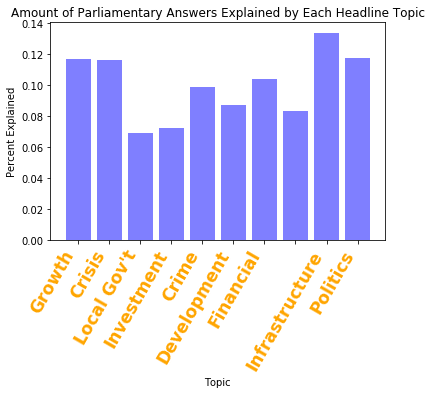

In [76]:
#Sum amount explained per topic, normalize, and plot
sum_explained_per_topic = []

for i in range(num_topics):
    sum_explained_per_topic.append(sum(answers_distribution_of_headline_topics[:,i]))
per_explained_per_topic = []

for i in range(num_topics):
    x = sum_explained_per_topic[i]/sum(sum_explained_per_topic)
    per_explained_per_topic.append(x)

    #plot
plt.bar(range(10), per_explained_per_topic, facecolor='blue', alpha=0.5)
plt.xlabel('Topic')
plt.ylabel('Percent Explained')
labs = ('Growth', 'Crisis', "Local Gov't", 'Investment', 'Crime', 
        'Development', 'Financial', '', 'Infrastructure', 'Politics')

plt.xticks(np.arange(10), 
           labs, 
           color='orange', 
           rotation=60, fontweight='bold', 
           fontsize='17', 
           horizontalalignment='right')

plt.title('Amount of Parliamentary Answers Explained by Each Headline Topic')
plt.show()

2889 1516 1432


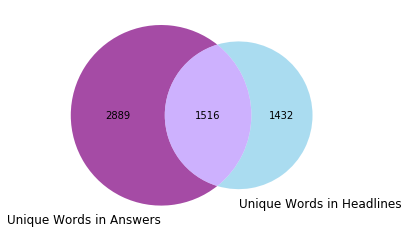

In [77]:
#Visualize the amount of words unique to each dataset and shared among the datasets
in_both = 0
in_answers_only = 0
in_headlines_only = 0

#Use TfidfVectorizer to transform parliamentary answers
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=200, stop_words="english", max_df=0.8)
answers_fit = vectorizer.fit(processed_answers)
X_answers = vectorizer.fit_transform(processed_answers).toarray()

for word in answers_fit.vocabulary_:
    if word in headlines_fit.vocabulary_:
        in_both += 1
    else:
        in_answers_only += 1
for word in headlines_fit.vocabulary_:
    if word not in answers_fit.vocabulary_:
        in_headlines_only += 1
        
print(in_answers_only, in_both, in_headlines_only)
venn2(subsets = (in_answers_only, in_headlines_only, in_both), 
      set_labels = ("Unique Words in Answers", 
                    "Unique Words in Headlines"),
      set_colors=('purple', 'skyblue'), alpha = 0.7);

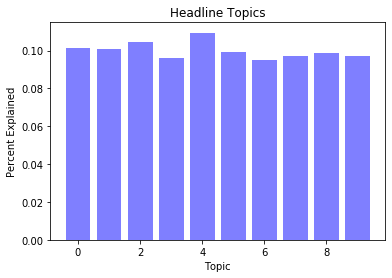

In [78]:
#Plot topic distribution for the headlines dataset itself to establish baseline
X_headlines_sample = X_headlines[np.random.choice(X_headlines.shape[0], 
                                                  10000, 
                                                  replace=False)]

headline_topic_distribution = lda_headlines.transform(X_headlines_sample)

sum_explained_per_topic = []
for i in range(num_topics):
    sum_explained_per_topic.append(sum(headline_topic_distribution[:,i]))
per_explained_per_topic = []

for i in range(num_topics):
    x = sum_explained_per_topic[i]/sum(sum_explained_per_topic)
    per_explained_per_topic.append(x)

plt.bar(range(10), per_explained_per_topic, facecolor='blue', alpha=0.5)
plt.xlabel('Topic')
plt.ylabel('Percent Explained')
plt.title('Headline Topics')
plt.show()

#### Running Clustering for speeches to check if financial clusters were more often found in Speeches vs real paliramentary discussions
##### This part was not featured in our presentation but was additional analysis that we attempted to do.
### Clustering for Parliament Datasets

In [81]:
#Create single parliament_qs dataframe with all question data
li = []

for file in glob.glob('./rajyasabha/rajyasabha_questions_and_answers_*.csv'):
    data = pd.read_csv(file, encoding='ISO-8859-1')
    li.append(data)
    
parliament_qs = pd.concat(li, axis = 0, ignore_index = True)

In [82]:
#Code borrowed and adapted from George Chen, Carnegie Mellon University#
#Define function to remove punctuation and whitespace, and lowercase all text
def makeWordList(str_object):
    
    corpus_text = str(str_object)
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [83]:
#Process the questions
processed_questions = []

for str_object in list(parliament_qs["question_description"]):
    processed_questions.append(makeWordList(str_object))

In [84]:
#Process responses
processed_answers = []

for str_object in list(parliament_qs["answer"]):
    processed_answers.append(makeWordList(str_object))

In [85]:
#Use TfidfVectorizer to transform parliamentary questions
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df=2, stop_words="english", max_df=0.8)
questions_fit = vectorizer.fit(processed_questions[:200])
X_questions = vectorizer.fit_transform(processed_questions[:200]).toarray()

In [86]:
doc_vocab = vectorizer.vocabulary_

In [87]:
#Use TfidfVectorizer to transform parliamentary questions
from sklearn.feature_extraction.text import TfidfVectorizer

a_vectorizer = TfidfVectorizer(min_df=2, stop_words="english", max_df=0.8)
answers_fit = a_vectorizer.fit(processed_answers[:200])
X_answers = a_vectorizer.fit_transform(processed_answers[:200]).toarray()

In [88]:
a_doc_vocab = a_vectorizer.vocabulary_
a_doc_vocab

{'commerce': 286,
 'industry': 855,
 'shri': 1607,
 'anand': 81,
 'sharma': 1597,
 'statement': 1664,
 'laid': 942,
 'table': 1733,
 'house': 796,
 'referred': 1422,
 'reply': 1457,
 'parts': 1213,
 'rajya': 1389,
 'sabha': 1526,
 'starred': 1662,
 'question': 1376,
 'answer': 100,
 'december': 427,
 'regarding': 1427,
 'prices': 1300,
 'gold': 742,
 'yes': 1876,
 'sir': 1620,
 'increase': 839,
 'international': 888,
 'markets': 1025,
 'seasonal': 1551,
 'demand': 445,
 'major': 1003,
 'investment': 895,
 'factors': 630,
 'known': 936,
 'broadly': 207,
 'government': 750,
 'control': 364,
 'present': 1292,
 'indian': 844,
 'functioning': 720,
 'region': 1429,
 'posts': 1276,
 'marketing': 1024,
 'provided': 1350,
 'said': 1528,
 'exclusively': 604,
 'look': 990,
 'trade': 1763,
 'related': 1442,
 'matters': 1029,
 'exporters': 615,
 'importers': 822,
 'undertake': 1787,
 'business': 214,
 'vice': 1827,
 'focus': 682,
 'programme': 1332,
 'force': 692,
 'incentives': 829,
 'promotional'

In [89]:
#Perform CLustering
from sklearn.mixture import GaussianMixture
 
gmm = GaussianMixture(n_components=10, n_init=10, random_state=0)
gmm.fit(X_questions)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=10,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [90]:
#Perform CLustering
from sklearn.mixture import GaussianMixture
 
a_gmm = GaussianMixture(n_components=10, n_init=10, random_state=0)
a_gmm.fit(X_answers)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=10,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [91]:
gmm_cluster_assignments = gmm.predict(X_questions)

for i in range(6):
        print("Number of questions in cluster", i , "are:" , sum(gmm_cluster_assignments == i))

Number of questions in cluster 0 are: 18
Number of questions in cluster 1 are: 25
Number of questions in cluster 2 are: 16
Number of questions in cluster 3 are: 18
Number of questions in cluster 4 are: 26
Number of questions in cluster 5 are: 18


In [92]:
a_gmm_cluster_assignments = a_gmm.predict(X_answers)

for i in range(6):
        print("Number of answers in cluster", i , "are:" , sum(a_gmm_cluster_assignments == i))

Number of answers in cluster 0 are: 16
Number of answers in cluster 1 are: 28
Number of answers in cluster 2 are: 22
Number of answers in cluster 3 are: 27
Number of answers in cluster 4 are: 11
Number of answers in cluster 5 are: 23


In [93]:
def plot_rel_words_by_cluster(predicted, n_clusters, fin_indices, other_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_fin = []
    mean_tfidf_other = []
    for fin in fin_indices:
        mean_tfidf_fin.append([])
    for other in other_indices:
        mean_tfidf_other.append([])
    
    for i in range(n_clusters):
        for j, fin_idx in enumerate(fin_indices):
            mean_tfidf_fin[j].append(X_questions[predicted==i, fin_idx].mean())
        for j, other_idx in enumerate(other_indices):
            mean_tfidf_other[j].append(X_questions[predicted==i, other_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot rel bars
    for i, val in enumerate(mean_tfidf_fin):
        fin_bar = ax.bar(ind - (len(mean_tfidf_fin)-i-1)*width, val, width, color='r', bottom=0)

    # Plot govt bars
    for i, val in enumerate(mean_tfidf_other):
        other_bar = ax.bar(ind + (len(mean_tfidf_other)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Finance-Relevant Words in Parliament Questions')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((fin_bar[0], other_bar[0]), ('Financial words', 'other words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [94]:
def plot_rel_words_by_cluster_a(predicted, n_clusters, fin_indices, other_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_fin = []
    mean_tfidf_other = []
    for fin in fin_indices:
        mean_tfidf_fin.append([])
    for other in other_indices:
        mean_tfidf_other.append([])
    
    for i in range(n_clusters):
        for j, fin_idx in enumerate(fin_indices):
            mean_tfidf_fin[j].append(X_answers[predicted==i, fin_idx].mean())
        for j, other_idx in enumerate(other_indices):
            mean_tfidf_other[j].append(X_answers[predicted==i, other_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot rel bars
    for i, val in enumerate(mean_tfidf_fin):
        fin_bar = ax.bar(ind - (len(mean_tfidf_fin)-i-1)*width, val, width, color='r', bottom=0)

    # Plot govt bars
    for i, val in enumerate(mean_tfidf_other):
        other_bar = ax.bar(ind + (len(mean_tfidf_other)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Finance-Relevant Words in Parliament Answers')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((fin_bar[0], other_bar[0]), ('Financial words', 'other words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [95]:
#Identifying three words from questions and answers each that would more significantly appear
#as part of financial discussions

#From Questions
#3 Finance words chosen:
financial = ['prices', 'trade', 'business']
fin_indices = [i for i, t in enumerate(doc_vocab) if t in financial]

#3 random words chosen:
other = ['reasons', 'policy', 'indian']
other_indices = [i for i, t in enumerate(doc_vocab) if t in other]

#From answers
#3 Finance words chosen:
a_financial = ['prices', 'trade', 'business']
a_fin_indices = [i for i, t in enumerate(a_doc_vocab) if t in a_financial]


#3 random words chosen:
a_other = ['reasons', 'policy', 'indian']
a_other_indices = [i for i, t in enumerate(a_doc_vocab) if t in a_other]


print("The indices for financial words chosen from questions are", fin_indices)
print()
print("The indices for random words chosen from questions are", other_indices)
print()
print("The indices for financial words chosen from answer are", a_fin_indices)
print()
print("The indices for random words chosen from answers are", a_other_indices)

The indices for financial words chosen from questions are [2, 17, 25]

The indices for random words chosen from questions are [6, 9, 27]

The indices for financial words chosen from answer are [19, 45, 51]

The indices for random words chosen from answers are [36, 134, 808]


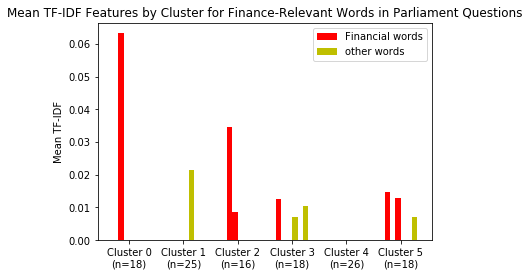

In [96]:
#Plot for Questions
import matplotlib.pyplot as plt
plot_rel_words_by_cluster(gmm_cluster_assignments, 6, fin_indices, other_indices)

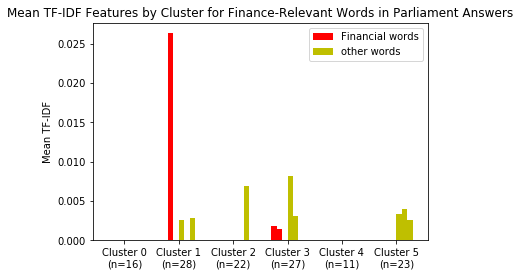

In [97]:
#Plot for Questions
import matplotlib.pyplot as plt
plot_rel_words_by_cluster_a(a_gmm_cluster_assignments, 6, a_fin_indices, a_other_indices)

### Clustering Modi Speeches

In [99]:
#Create single list to hold all of Modi speeches

speech = []

for file in glob.glob('./Modi_Speeches/*.txt'):
    new = open(file, 'r', encoding="ascii", errors="surrogateescape").read().replace("/n" ,"")
    speech.append(new)

speech

['My dear countrymen, greetings to all of you! I have the opportunity to be amongst you to share my Mann Ki Baat once again. Far south, the people are engrossed in Onam festivities and yesterday the entire Nation celebrated the holy festival of Raksha Bandhan. The government of India has launched various schemes of social security for the common man. I am happy that in a very short span of time all these schemes have been accepted in large numbers.\nI had made a humble request that on the occasion of Raksha Bandhan we give our sisters these insurance schemes as a gift. The preliminary information that I have, notifies me that from launch till date around 11 crore families have joined this scheme. And I have been told that almost half the beneficiaries are women, the mothers and the daughters. I consider this as a positive sign. I offer my best wishes to all mothers and sisters on this blessed occasion of Raksha Bandhan.\nToday when I talk to you, I want to mention that around a year ba

In [100]:
#Code borrowed and adapted from George Chen, Carnegie Mellon University#
#Define function to remove punctuation and whitespace, and lowercase all text

def makeWordList(str_object):
    
    corpus_text = str(str_object)
    
    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [101]:
#Process the speech
processed_speech = []

for str_object in speech:
    processed_speech.append(makeWordList(str_object))

In [102]:
#Use TfidfVectorizer to transform parliamentary questions
from sklearn.feature_extraction.text import TfidfVectorizer

s_vectorizer = TfidfVectorizer(min_df=2, stop_words="english", max_df=0.8)
speech_fit   = s_vectorizer.fit(processed_speech[:20])
X_speech     = s_vectorizer.fit_transform(processed_speech[:20]).toarray()

In [103]:
s_doc_vocab = s_vectorizer.vocabulary_
s_doc_vocab

{'greetings': 1099,
 'far': 906,
 'south': 2431,
 'engrossed': 795,
 'onam': 1764,
 'festivities': 939,
 'yesterday': 2913,
 'celebrated': 330,
 'holy': 1194,
 'festival': 936,
 'raksha': 2060,
 'bandhan': 184,
 'launched': 1438,
 'various': 2785,
 'schemes': 2276,
 'social': 2406,
 'security': 2307,
 'common': 416,
 'man': 1544,
 'happy': 1137,
 'short': 2366,
 'span': 2435,
 'accepted': 11,
 'large': 1432,
 'numbers': 1736,
 'humble': 1217,
 'request': 2150,
 'occasion': 1745,
 'sisters': 2392,
 'insurance': 1324,
 'gift': 1059,
 'preliminary': 1948,
 'information': 1292,
 'launch': 1437,
 'till': 2634,
 'date': 552,
 'families': 904,
 'joined': 1374,
 'scheme': 2275,
 'told': 2643,
 'half': 1125,
 'beneficiaries': 212,
 'women': 2878,
 'mothers': 1662,
 'daughters': 554,
 'consider': 464,
 'positive': 1915,
 'sign': 2378,
 'offer': 1750,
 'wishes': 2870,
 'blessed': 239,
 'talk': 2571,
 'mention': 1605,
 'jan': 1364,
 'dhan': 618,
 'yojana': 2916,
 'started': 2473,
 'scale': 2267,
 

In [104]:
#Perform CLustering
from sklearn.mixture import GaussianMixture
 
s_gmm = GaussianMixture(n_components=6, n_init=10, random_state=0)
s_gmm.fit(X_speech)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=6, n_init=10,
                precisions_init=None, random_state=0, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [105]:
s_gmm_cluster_assignments = s_gmm.predict(X_speech)

for i in range(6):
        print("Number of questions in cluster", i , "are:" , sum(gmm_cluster_assignments == i))

Number of questions in cluster 0 are: 18
Number of questions in cluster 1 are: 25
Number of questions in cluster 2 are: 16
Number of questions in cluster 3 are: 18
Number of questions in cluster 4 are: 26
Number of questions in cluster 5 are: 18


In [106]:
def plot_fin_words_by_cluster(predicted, n_clusters, fin_indices, other_indices):
    import numpy as np
    import matplotlib.pyplot as plt
    
    # Calculate mean TF-IDF features for each cluster
    mean_tfidf_fin = []
    mean_tfidf_other = []
    for fin in fin_indices:
        mean_tfidf_fin.append([])
    for other in other_indices:
        mean_tfidf_other.append([])
    
    for i in range(n_clusters):
        for j, fin_idx in enumerate(fin_indices):
            mean_tfidf_fin[j].append(X_speech[predicted==i, fin_idx].mean())
        for j, other_idx in enumerate(other_indices):
            mean_tfidf_other[j].append(X_speech[predicted==i, other_idx].mean())
    
    # Generate plot
    fig, ax = plt.subplots()

    ind = np.arange(n_clusters)    # the x locations for the groups
    width = 0.10         # the width of the bars

    # Plot rel bars
    for i, val in enumerate(mean_tfidf_fin):
        fin_bar = ax.bar(ind - (len(mean_tfidf_fin)-i-1)*width, val, width, color='r', bottom=0)

    # Plot govt bars
    for i, val in enumerate(mean_tfidf_other):
        other_bar = ax.bar(ind + (len(mean_tfidf_other)-i)*width, val, width,
                color='y', bottom=0)

    ax.set_title('Mean TF-IDF Features by Cluster for Finance-Relevant Words in Modi Speeches')
    ax.set_xticks(ind + width / 2)
    xticklabels = []
    for i in range(n_clusters):
        xticklabels.append('Cluster ' + str(i) + '\n(n=' + str((predicted==i).sum()) + ')')
    ax.set_xticklabels(xticklabels)

    ax.legend((fin_bar[0], other_bar[0]), ('Fin words', 'Other words'))
    ax.autoscale_view()
    ax.set_ylabel('Mean TF-IDF')
    plt.show()

In [107]:
#3 financial words

s_financial = ['spend', 'fine', 'economic']
s_fin_indices = [i for i, t in enumerate(s_doc_vocab) if t in s_financial]

s_other = ['distressed', 'grief', 'crisis']
s_other_indices = [i for i, t in enumerate(s_doc_vocab) if t in s_other]

print("The indices for fin words chosen are", s_fin_indices)
print()
print("The indices for other words chosen are", s_other_indices)

The indices for fin words chosen are [534, 884, 2203]

The indices for other words chosen are [887, 2877, 2880]


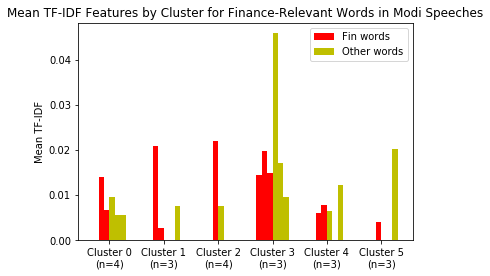

In [108]:
import matplotlib.pyplot as plt
plot_fin_words_by_cluster(s_gmm_cluster_assignments, 6, s_fin_indices, s_other_indices)

### Topic Modelling for Speeches

In [109]:
#Use CountVectorizer to speeches dataset
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=2, stop_words="english", max_df=0.8)
speech_fit = vectorizer.fit(processed_speech)
X_speech = vectorizer.fit_transform(processed_speech).toarray()

In [110]:
#!Time-consuming!#
#Create topics using LDA
num_topics = 10

from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=0)
lda.fit(X_speech)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=10, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [111]:
#Display top 10 words from each topic
words = list(speech_fit.vocabulary_)
topic_word_distributions = np.array([row / row.sum() for row in lda.components_])
num_top_words = 10

print('Displaying the top 10 words per topic and their probabilities within the topic...')
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(-topic_word_distributions[topic_idx])
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(words[word_idx], ':', topic_word_distributions[topic_idx, word_idx])
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
value : 0.007175936655669052
krishna : 0.006391846966240305
priorities : 0.005614152325743469
genuine : 0.005214837660599011
crops : 0.004643963395163252
remain : 0.004066629983726877
point : 0.003723148897758396
sewak : 0.0036663523006354643
processes : 0.003317523010995086
copper : 0.0032847613328061682

[Topic 1]
fifa : 0.000701708662883824
play : 0.0006818301150462846
repeatedly : 0.0006793051157255865
sister : 0.0006427422271346029
posted : 0.0006422327401034738
wily : 0.000632309972196516
anger : 0.0006308219924229688
unit : 0.0005880994378064003
introduced : 0.0005855489119598086
woman : 0.0005843034849271489

[Topic 2]
integral : 0.0011313131867720038
anger : 0.0010960021762803215
unit : 0.000686513103282933
repeatedly : 0.0006489789817300973
wily : 0.0006458784096514072
careless : 0.0006445418564251383
touched : 0.0006206612488662205
welfare : 0.0006193087420696037
grace : 0.0005927600

# Conclusions
There was little to no change in religious rhetoric in the media or upper house of India’s parliament based on the datasets that we had access to. The upper house of parliament seems to focus more on crises, crime, and development than the media, which is an interesting finding. However, it is important to notice that there is the potential for one aggregate "financial" column that topic modeling does not quite account for. Should those categories be aggregated instead of divided into the subcategories we see in our topics, the rankng of important topics in the parliament answers would be more intuitive.

### Insights
Analysis of public data sources provides important insights and will continue to provide important insights. A huge limitation for this project was the data that was available to us. It's important to allow transparency in government (e.g. to provide a wider source of government datasets) so that proper attention can be paid to changing environments.
